## Install packages

In [1]:
%%capture
!python -m pip install --upgrade pip
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install mne=="0.23" #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.

## Import

In [2]:
from typing import Dict


from gcpds.databases import GIGA_MI_ME
from google.colab.drive import mount
import numpy as np
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from MI_EEG_ClassMeth.FeatExtraction import Power_based_Connectivities
from mne import create_info
from mne.channels import make_standard_montage
from pickle import load as pload
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Utils

In [3]:
import numpy as np
from matplotlib import pyplot as plt


# ----------------------------------------------------------------------
def agco(method_1, method_2, ticks, labels, sort='method_1', reference_c='C1', gain_c='C0', loss_c='C3', barwidth=8, ylabel='Accuracy [%]', xlabel='Subjects', gain_labels=['gain', 'loss'], fig=None, ax=None, size=(15, 5), dpi=90, **kwargs):
    """"""
    if 'lose_c' in kwargs:
        loss_c = kwargs['lose_c']

    if fig is None:
        plt.figure(figsize=size, dpi=dpi)

    if ax is None:
        ax = plt.subplot(111)

    if sort is None:
        index = np.arange(len(method_2))
    elif sort == 'method_1':
        index = np.argsort(method_1)[::-1]
    elif sort == 'method_1r':
        index = np.argsort(method_1)
    elif sort == 'method_2':
        index = np.argsort(method_2)[::-1]
    elif sort == 'method_2r':
        index = np.argsort(method_2)

    colors = np.array(method_2[index]
                      - method_1[index] < 0, dtype=np.object_)

    if sort is None or sort.startswith('method_1'):
        p1, = plt.plot(method_1[index], color=reference_c, linestyle='--', linewidth=3)
        p2, = plt.plot(method_2[index], color=gain_c,
                       linestyle='--', linewidth=3, alpha=0.5)
        colors[colors == 0] = gain_c
        colors[colors == 1] = loss_c
    elif sort.startswith('method_2'):
        p1, = plt.plot(method_2[index], color=reference_c, linestyle='--',)
        p2, = plt.plot(method_1[index], color=gain_c,
                       linestyle='--', alpha=0.3)
        colors[colors == 0] = loss_c
        colors[colors == 1] = gain_c

    plots = [p1, p2]

    if np.array([colors == gain_c]).any():
        p3 = plt.vlines(np.array(sorted(index))[colors == gain_c], method_1[index][colors == gain_c],
                        method_2[index][colors == gain_c], color=colors[colors == gain_c], linewidth=barwidth)
        labels.append(gain_labels[0])
        plots.append(p3)

    if np.array([colors == loss_c]).any():
        p4 = plt.vlines(np.array(sorted(index))[colors == loss_c], method_1[index][colors == loss_c],
                        method_2[index][colors == loss_c], color=colors[colors == loss_c], linewidth=barwidth)
        labels.append(gain_labels[1])
        plots.append(p4)

    plt.ylabel(ylabel, fontsize=35)
    plt.xlabel(xlabel)
    plt.yticks(range(50, 101, 10), range(50, 101, 10), fontsize=25)
    plt.xticks(range(len(ticks)), ticks[index], rotation=90, fontsize=22)

    try:
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
    except:
        pass

    try:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    except:
        pass

    l1 = plt.legend(plots, labels, loc='upper center',
                    ncol=2, bbox_to_anchor=(0.5, 1), fontsize=25)
    plt.gca().add_artist(l1)

    return plt.gcf()

def plot_A(coord: np.ndarray, images: np.ndarray, zoom: float, cmap: str, grs_id: np.ndarray, group_colors: Dict[str, str], ax):
  for i in range(coord.shape[0]):
      im = OffsetImage(squareform(images[i]), zoom = zoom, cmap = cmap)
      img = im.get_children()[0]
      img.set_clim(vmin=0, vmax=1)
      ab = AnnotationBbox(im, (coord[i,0], coord[i,1]), pad = 0.2, bboxprops = dict(edgecolor = group_colors[str(grs_id[i])], lw = 6))
      ax.add_artist(ab)
      ax.update_datalim([(coord[i,0], coord[i,1])])
      ax.autoscale()
  return ax

## Variables definition

In [4]:
mount("/content/drive", force_remount=True)

parent_dir = '/content/drive/Shareddrives/GCPDS - Mateo/Mateo/MI_DL_models/GIGA_MI_ME/'

db = GIGA_MI_ME('/content/drive/Shareddrives/GCPDS-Databases/GIGA-MI_ME/')
fs = db.metadata['sampling_rate']
eeg_ch_names = ['Fp1','Fpz','Fp2',
              'AF7','AF3','AFz','AF4','AF8',
              'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
              'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
              'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
              'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
              'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
              'PO7','PO3','POz','PO4','PO8',
              'O1','Oz','O2',
              'Iz']
n_eeg_chs = len(eeg_ch_names)
montage = make_standard_montage(db.metadata['montage'])
info = create_info(eeg_ch_names, fs, len(eeg_ch_names)*['eeg'])
info.set_montage(montage)
subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects, [28,33])

seed = 23
n_groups = 3
cmap = plt.get_cmap('Pastel2')

pbc = Power_based_Connectivities()

raw_eegnet = np.load(parent_dir + 'EEGNet/raw_eegnet.npy')
reg_eegnet = np.load(parent_dir + 'RCKA_EEGNet/reg_eegnet.npy')
orig_raw_eegnet = raw_eegnet.copy()
orig_reg_eegnet = reg_eegnet.copy()
lambda_ = np.load(parent_dir + 'RCKA_EEGNet/lambda_.npy')
gammad = np.load(parent_dir + 'RCKA_EEGNet/gammad.npy')
H = np.load(parent_dir + 'RCKA_EEGNet/H.npy')
A_sbjs = np.load(parent_dir + 'RCKA_EEGNet/A_sbjs.npy')

Mounted at /content/drive


## Results

In [5]:
# Classification scores normalization
raw_eegnet[:, [1, 3, -1]] = 1 - raw_eegnet[:, [1, 3, -1]]
raw_eegnet[:, 2] = (raw_eegnet[:, 2] + 1)/2
reg_eegnet[:, [1, 3, -1]] = 1 - reg_eegnet[:, [1, 3, -1]]
reg_eegnet[:, 2] = (reg_eegnet[:, 2] + 1)/2

In [6]:
# Clustering based in performance
kmeans = KMeans(n_clusters = n_groups, random_state = seed)
grs_raw = kmeans.fit_predict(raw_eegnet)
grs_reg = kmeans.predict(reg_eegnet)

pca = PCA(n_components = 1, whiten = True).fit(raw_eegnet)
idx_ord_sbj = np.argsort(pca.transform(raw_eegnet)[:,0])
groups_id = np.argsort(pca.transform(kmeans.cluster_centers_)[:,0])

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Overall performance results

In [7]:
raw_eegnet_all_sbjs = np.concatenate([orig_raw_eegnet.mean(axis = 0, keepdims = True), orig_raw_eegnet.std(axis = 0, keepdims = True)], axis = 0)
reg_eegnet_all_sbjs = np.concatenate([orig_reg_eegnet.mean(axis = 0, keepdims = True), orig_reg_eegnet.std(axis = 0, keepdims = True)], axis = 0)

print('-----------------------------------------------------------------------------------')
print('Raw')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(raw_eegnet_all_sbjs[0, 0]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(raw_eegnet_all_sbjs[0, 2]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 2]*100, 1), ',mean_auc', round(raw_eegnet_all_sbjs[0, 4]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('Reg')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(reg_eegnet_all_sbjs[0, 0]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(reg_eegnet_all_sbjs[0, 2]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 2]*100, 1), ',mean_auc', round(reg_eegnet_all_sbjs[0, 4]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
Raw
-----------------------------------------------------------------------------------
mean_acc =  74.4 +/- 14.9 ,mean_kappa =  48.6 +/- 29.8 ,mean_auc 79.6 +/- 16.4
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
Reg
-----------------------------------------------------------------------------------
mean_acc =  77.9 +/- 13.2 ,mean_kappa =  55.7 +/- 26.5 ,mean_auc 82.5 +/- 14.5
-----------------------------------------------------------------------------------


In [8]:
ticks = ticks = np.asarray(['S' + str(sbj) for sbj in subjects[idx_ord_sbj]])

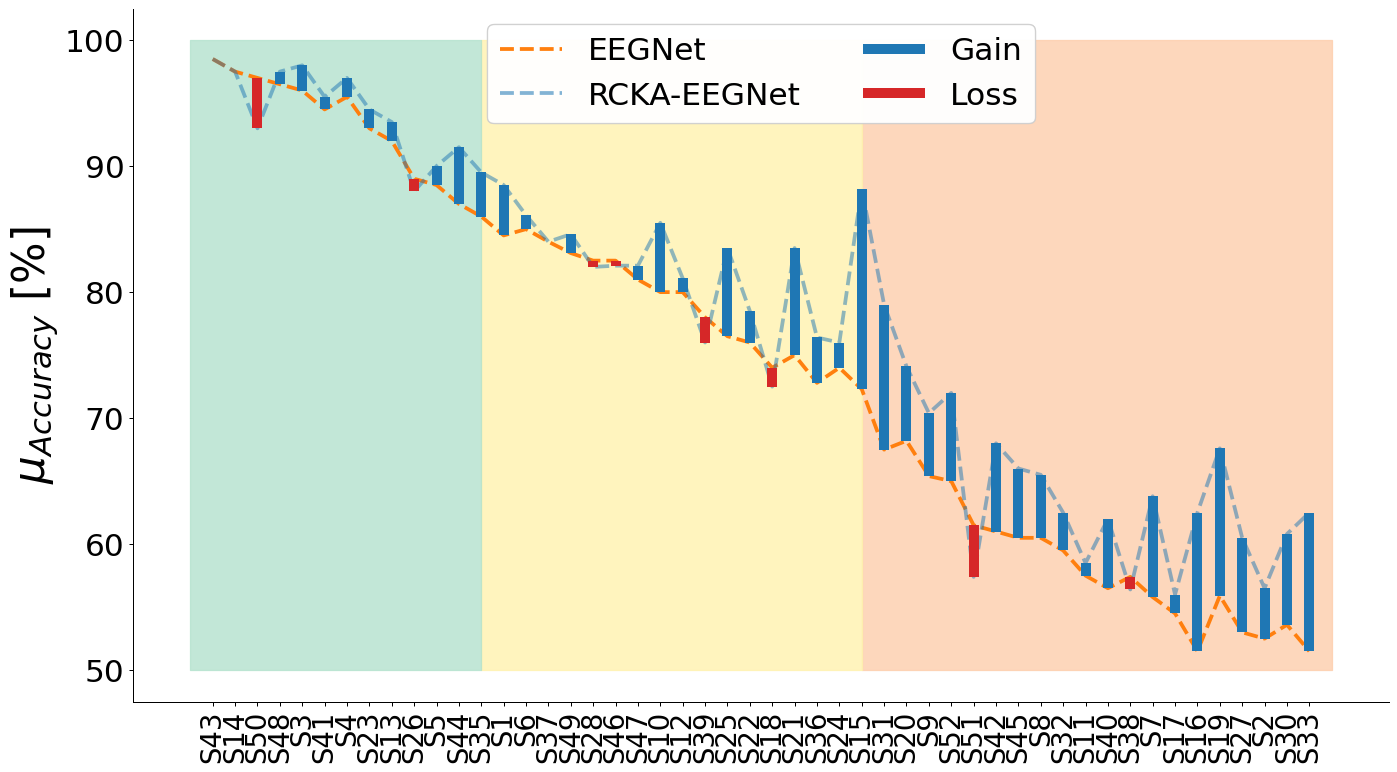

In [9]:
fig = agco( np.round(orig_raw_eegnet[idx_ord_sbj, 0]*100, 1), 
     np.round(orig_reg_eegnet[idx_ord_sbj, 0]*100, 1),
     ticks,
     ['EEGNet', 'RCKA-EEGNet'],
     sort=None,
     gain_labels=['Gain', 'Loss'],
     gain_c='C0',
     loss_c='C3',
     ylabel = r'$\mu_{Accuracy}$ [%]',
     xlabel = '',
     size=(18, 10))

f1 = plt.fill_betweenx([50, 100], 29, 50, color=cmap(1), alpha=0.8)
f2 = plt.fill_betweenx([50, 100], 12, 29, color=cmap(5), alpha=0.8)
f3 = plt.fill_betweenx([50, 100], -1, 12, color=cmap(0), alpha=0.8)

fig.savefig("sbjs_mean_acc.pdf")

- How to explain
1. Overall performance
2. Gain of indicidual subjects
3. How?



In [10]:
print('-----------------------------------------------------------------------------------')
print('Raw')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(raw_eegnet_all_sbjs[0, 1]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 1]*100, 1), ',mean_kappa = ', round(raw_eegnet_all_sbjs[0, 3]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 3]*100, 1), ',mean_auc', round(raw_eegnet_all_sbjs[0, -1]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, -1]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('Reg')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(reg_eegnet_all_sbjs[0, 1]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 1]*100, 1), ',mean_kappa = ', round(reg_eegnet_all_sbjs[0, 3]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 3]*100, 1), ',mean_auc', round(reg_eegnet_all_sbjs[0, -1]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, -1]*100, 1))
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
Raw
-----------------------------------------------------------------------------------
mean_acc =  5.9 +/- 2.4 ,mean_kappa =  11.8 +/- 4.8 ,mean_auc 5.9 +/- 3.9
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
Reg
-----------------------------------------------------------------------------------
mean_acc =  4.9 +/- 2.7 ,mean_kappa =  9.9 +/- 5.5 ,mean_auc 4.5 +/- 3.2
-----------------------------------------------------------------------------------


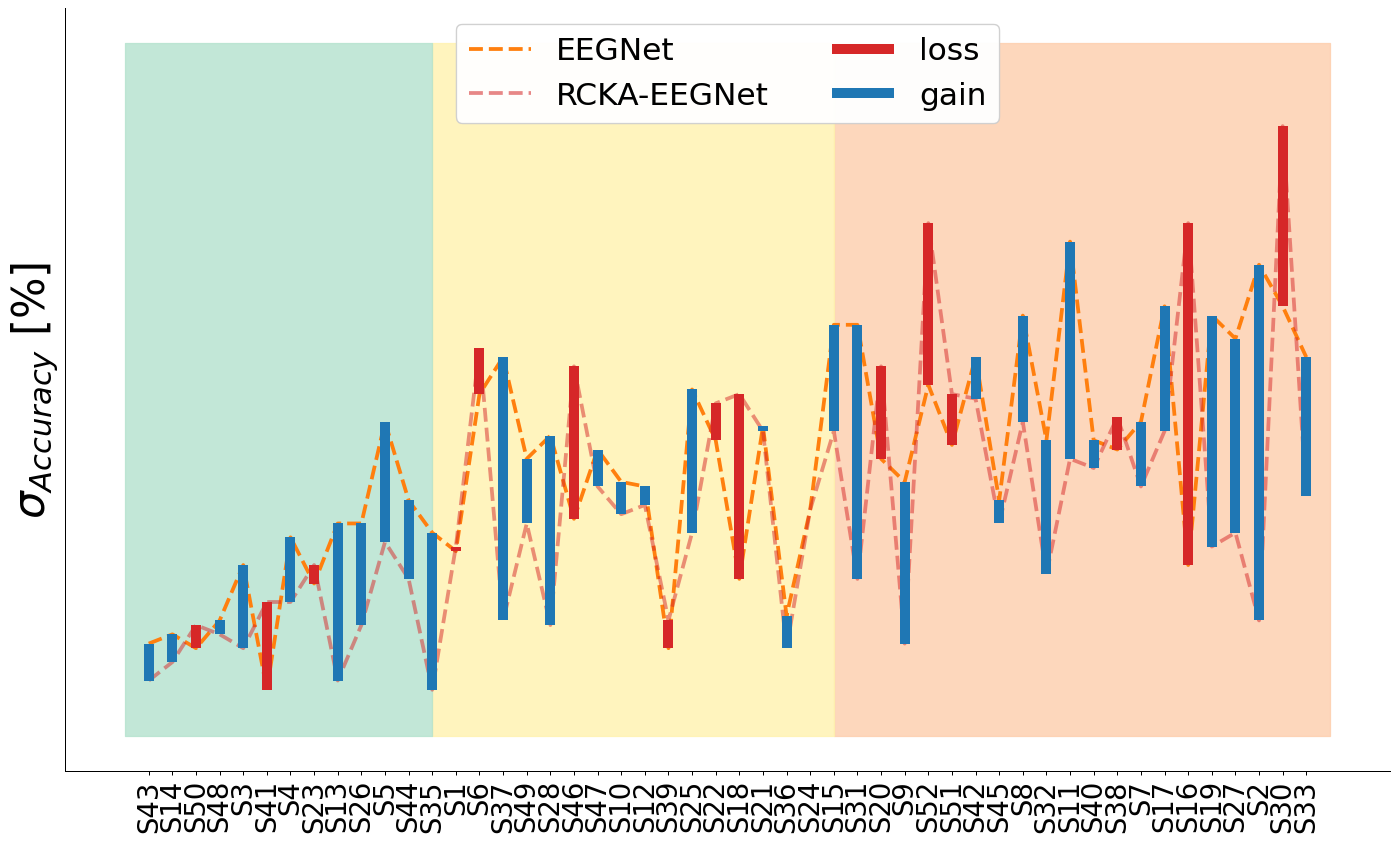

In [11]:
fig = agco( np.round(orig_raw_eegnet[idx_ord_sbj, 1]*100, 1), 
     np.round(orig_reg_eegnet[idx_ord_sbj, 1]*100, 1),
     ticks,
     ['EEGNet', 'RCKA-EEGNet'],
     sort=None,
     gain_labels=['loss', 'gain'],
     gain_c='C3',
     loss_c='C0',
     ylabel = r'$\sigma_{Accuracy}$ [%]',
     xlabel = '',
     size=(19, 11))

f1 = plt.fill_betweenx([0, 15], 29, 50, color=cmap(1), alpha=0.8)
f2 = plt.fill_betweenx([0, 15], 12, 29, color=cmap(5), alpha=0.8)
f3 = plt.fill_betweenx([0, 15], -1, 12, color=cmap(0), alpha=0.8)

fig.savefig("sbjs_std_acc.pdf")

- How to explain?
- How to relate to hyper parameters?, I mean, is λ related to the few stability in the bad subjectes for example?

### Performace

In [12]:
raw_eegnet_group = np.zeros((n_groups, 2, 3))
reg_eegnet_group = np.zeros((n_groups, 2, 3))

for idx, id in enumerate(groups_id):
  raw_eegnet_group[idx, 0] = raw_eegnet[grs_raw == id][:,[0, 2, 4]].mean(axis = 0)
  raw_eegnet_group[idx, 1] = raw_eegnet[grs_raw == id][:,[0, 2, 4]].std(axis = 0)
  reg_eegnet_group[idx, 0] = reg_eegnet[grs_raw == id][:,[0, 2, 4]].mean(axis = 0)
  reg_eegnet_group[idx, 1] = reg_eegnet[grs_raw == id][:,[0, 2, 4]].std(axis = 0)

raw_eegnet_group = np.round(raw_eegnet_group*100, 1)
reg_eegnet_group = np.round(reg_eegnet_group*100, 1)

print('-----------------------------------------------------------------------------------')
print('Raw')
print('-----------------------------------------------------------------------------------')
print('G.I:','mean_acc = ', raw_eegnet_group[0,0,0], '+/-', raw_eegnet_group[0,1,0], ',mean_kappa = ', raw_eegnet_group[0,0,1], '+/-', raw_eegnet_group[0,1,1], ',mean_auc', raw_eegnet_group[0,0,2], '+/-', raw_eegnet_group[0,1,2])
print('G.II:','mean_acc = ', raw_eegnet_group[1,0,0], '+/-', raw_eegnet_group[1,1,0], ',mean_kappa = ', raw_eegnet_group[1,0,1], '+/-', raw_eegnet_group[1,1,1], ',mean_auc', raw_eegnet_group[1,0,2], '+/-', raw_eegnet_group[1,1,2])
print('G.III:','mean_acc = ', raw_eegnet_group[2,0,0], '+/-', raw_eegnet_group[2,1,0], ',mean_kappa = ', raw_eegnet_group[2,0,1], '+/-', raw_eegnet_group[2,1,1], ',mean_auc', raw_eegnet_group[2,0,2], '+/-', raw_eegnet_group[2,1,2])
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('Reg')
print('-----------------------------------------------------------------------------------')
print('G.I:','mean_acc = ', reg_eegnet_group[0,0,0], '+/-', reg_eegnet_group[0,1,0], ',mean_kappa = ', reg_eegnet_group[0,0,1], '+/-', reg_eegnet_group[0,1,1], ',mean_auc', reg_eegnet_group[0,0,2], '+/-', reg_eegnet_group[0,1,2])
print('G.II:','mean_acc = ', reg_eegnet_group[1,0,0], '+/-', reg_eegnet_group[1,1,0], ',mean_kappa = ', reg_eegnet_group[1,0,1], '+/-', reg_eegnet_group[1,1,1], ',mean_auc', reg_eegnet_group[1,0,2], '+/-', reg_eegnet_group[1,1,2])
print('G.III:','mean_acc = ', reg_eegnet_group[2,0,0], '+/-', reg_eegnet_group[2,1,0], ',mean_kappa = ', reg_eegnet_group[2,0,1], '+/-', reg_eegnet_group[2,1,1], ',mean_auc', reg_eegnet_group[2,0,2], '+/-', reg_eegnet_group[2,1,2])
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
Raw
-----------------------------------------------------------------------------------
G.I: mean_acc =  93.2 +/- 4.1 ,mean_kappa =  93.2 +/- 4.1 ,mean_auc 97.8 +/- 2.1
G.II: mean_acc =  78.9 +/- 4.2 ,mean_kappa =  78.9 +/- 4.2 ,mean_auc 87.4 +/- 4.4
G.III: mean_acc =  58.4 +/- 5.1 ,mean_kappa =  58.2 +/- 4.7 ,mean_auc 61.2 +/- 6.8
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
Reg
-----------------------------------------------------------------------------------
G.I: mean_acc =  94.2 +/- 3.4 ,mean_kappa =  94.2 +/- 3.4 ,mean_auc 97.8 +/- 2.4
G.II: mean_acc =  81.8 +/- 4.4 ,mean_kappa =  81.8 +/- 4.4 ,mean_auc 89.0 +/- 4.4
G.III: mean_acc =  64.1 +/- 6.1 ,mean_kappa =  63.9 +/- 5.8 ,mean_auc 67.0 +/- 8.5
------------------------------------------------------------------------------

- How to explain

### Group transition

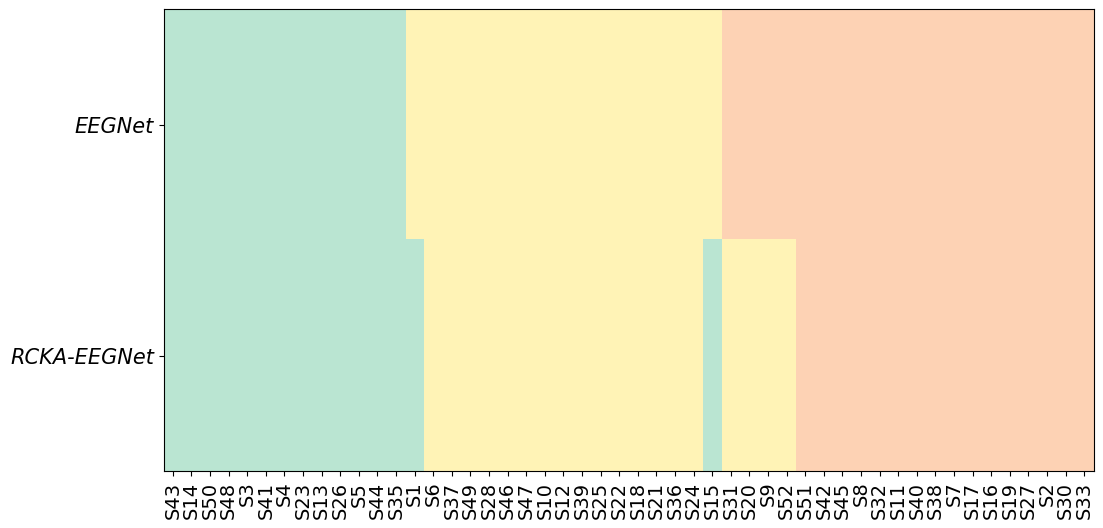

In [13]:
comparison_grs = np.stack([grs_raw, grs_reg], axis = 0)

colors = [cmap(1), cmap(5), cmap(0)]
sub_cmap = mpl.colors.ListedColormap(colors)

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 6))

_ = axs.imshow(comparison_grs[:, idx_ord_sbj], aspect = 'auto', cmap = sub_cmap, alpha = 0.9)
_ = axs.set_yticks(np.arange(2))
_ = axs.set_yticklabels(['EEGNet', 'RCKA-EEGNet'], fontsize = 15, style = 'italic')
_ = axs.set_xticks(np.arange(ticks.shape[0]))
_ = axs.set_xticklabels(ticks, fontsize = 14, rotation = 90)

fig.savefig("traffic_light.pdf")

- Gain?

### Hyperparameters

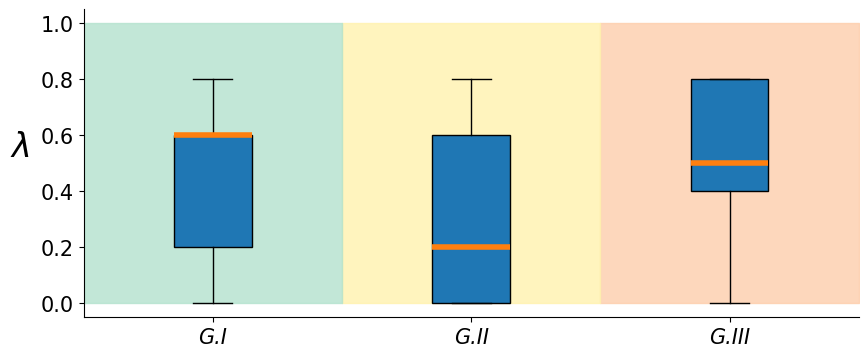

In [14]:
grs_lambda_ = [lambda_[grs_raw == idx] for idx in groups_id]

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

axs.boxplot(grs_lambda_, patch_artist = True, labels = ['G.I', 'G.II', 'G.III'], medianprops={"linewidth": 4,
                        "solid_capstyle": "butt"})
axs.set_xticks(ticks=[1, 2, 3], labels=['G.I', 'G.II', 'G.III'], fontsize=15, style = 'italic')
axs.set_yticks(ticks=np.arange(0, 1.1, 0.2), labels=np.round(np.arange(0, 1.1, 0.2), 1), fontsize=15)
axs.set_ylabel(r'$\lambda$', rotation = 0, fontsize = 24, labelpad = 15)
f1 = plt.fill_betweenx([0, 1], 2.5, 3.5, color=cmap(1), alpha=0.8)
f2 = plt.fill_betweenx([0, 1], 1.5, 2.5, color=cmap(5), alpha=0.8)
f3 = plt.fill_betweenx([0, 1], 0.5, 1.5, color=cmap(0), alpha=0.8)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

fig.savefig("lambda.pdf")

- Good group: Search good connectivities 
- Middle group:
- Bad groups: Clean high noise.

New chart = lambda vs subjects. (Twin plot (acc vs perf vs sub))

Both figures.

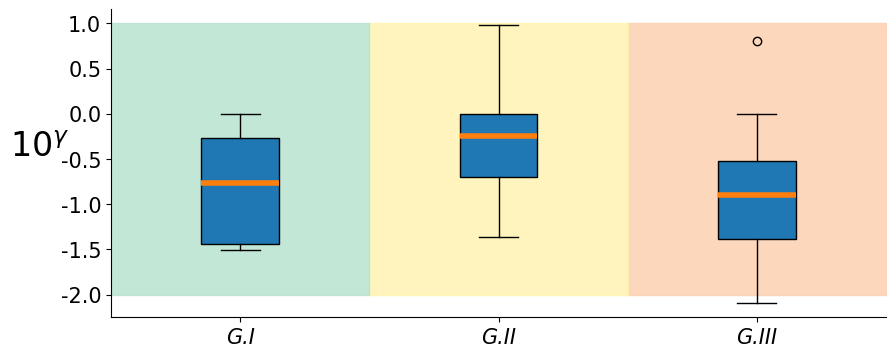

In [16]:
grs_gammad = [gammad[grs_raw == idx] for idx in groups_id]

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

axs.boxplot(grs_gammad, patch_artist = True, labels = ['G.I', 'G.II', 'G.III'], medianprops={"linewidth": 4,
                        "solid_capstyle": "butt"})
axs.set_ylabel(r'$10^{\gamma}$', rotation = 0, fontsize = 24, labelpad = 15)
axs.set_xticks(ticks=[1, 2, 3], labels=['G.I', 'G.II', 'G.III'], fontsize=15, style = 'italic')
axs.set_yticks(ticks=np.arange(-2, 1.1, 0.5), labels=np.round(np.arange(-2, 1.1, 0.5), 1), fontsize=15)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
f1 = plt.fill_betweenx([-2.0, 1], 2.5, 3.5, color=cmap(1), alpha=0.8)
f2 = plt.fill_betweenx([-2.0, 1], 1.5, 2.5, color=cmap(5), alpha=0.8)
f3 = plt.fill_betweenx([-2.0, 1], 0.5, 1.5, color=cmap(0), alpha=0.8)

fig.savefig("gamma.pdf")

-  Transform to 10^lambda (Shrink bar plots)
- Same chart
- Explain realtion lambda vs gamma (Highlight CKA and effect of gamma in FC, **strong filtering in the RKHS**)

 - Correlation between λ and γ (How to explain?)
 - Explain in terms of performace and explanability.
 - IMPORTANT

### Intra subject variability

- How to explain?

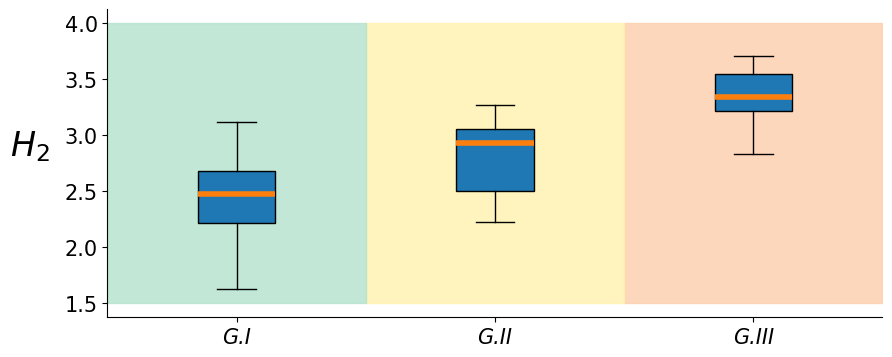

In [17]:
grs_H = [H[grs_reg == idx] for idx in groups_id]

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

axs.boxplot(grs_H, patch_artist = True, labels = ['G.I', 'G.II', 'G.III'], medianprops={"linewidth": 4,
                        "solid_capstyle": "butt"})
axs.set_xticks(ticks=[1, 2, 3], labels=['G.I', 'G.II', 'G.III'], fontsize=15, style = 'italic')
axs.set_yticks(ticks=np.arange(1.5, 4.1, 0.5), labels=np.round(np.arange(1.5, 4.1, 0.5), 1), fontsize=15)
axs.set_ylabel(r'$H_{2}$', rotation = 0, fontsize = 24, labelpad = 25)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
f1 = plt.fill_betweenx([1.5, 4], 2.5, 3.5, color=cmap(1), alpha=0.8)
f2 = plt.fill_betweenx([1.5, 4], 1.5, 2.5, color=cmap(5), alpha=0.8)
f3 = plt.fill_betweenx([1.5, 4], 0.5, 1.5, color=cmap(0), alpha=0.8)

fig.savefig("renyis_entropy_2.pdf")

Above plots explain the CKA regularizer parameter.

### Explanability

#### Performance vs FC pattern

In [ ]:
dim_red = TSNE(n_components = 2, perplexity = 10, learning_rate = 'auto', init = 'pca', random_state = seed)
raw_eegnet_tsne = dim_red.fit_transform(raw_eegnet)
reg_eegnet_tsne = dim_red.fit_transform(reg_eegnet)

In [ ]:
groups_colors = {str(groups_id[0]):cmap(0), str(groups_id[1]):cmap(5), str(groups_id[2]):cmap(1)}
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 15))
GI_patch = mpatches.Patch(color = cmap(1), label = 'G.III')
GII_patch = mpatches.Patch(color = cmap(5), label = 'G.II')
GIII_patch = mpatches.Patch(color = cmap(0), label = 'G.I')

ax = plot_A(reg_eegnet_tsne, A_sbjs, 0.7, 'jet', grs_reg, groups_colors, ax)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(handles = [GI_patch, GII_patch, GIII_patch], prop = {'size': 24}, loc="upper center")
ax.set_facecolor('gray')
fig.savefig("kolmogorov_matrix.pdf")

- How to explain
1. Sparsity in bad groups
2. Good group: Turn on

#### Topoplots

In [ ]:
coef = np.stack([np.median(A_sbjs[grs_reg==groups_id[0]], axis=0),
                 np.median(A_sbjs[grs_reg==groups_id[1]], axis=0),
                 np.median(A_sbjs[grs_reg==groups_id[2]], axis=0)], axis=1)

In [ ]:
# MEDIAN (winner)
pbc.plot_connectivities(coef.reshape(-1).copy(), info, eeg_ch_names, n_vwt=1, n_f_bank=n_groups, min_max_normalization_type="frequency", thr=0.8,
                        w_label=None, fb_label=['G. I', 'G. II', 'G. III'], labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':30, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':26},
                        relevant_channels=False, plot_channels_names=False, figsize=(12,8), cmap_connectivities='jet', cmap_tplt='Purples', save=True, path='group_topoplots', format='pdf')

- How to explain ?
- What are the main points to explain.